In [10]:
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from queries import Simbad
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
import matplotlib.ticker as ticker
from matplotlib.backends.backend_pdf import PdfPages
import pickle
import os

% matplotlib inline
#top_level='/Users/codydirks/PGCC/'
top_level='/DataDisk/datafiles/PGCC_HST/'

class LineInfo(object):
    def __init__(self,dat_line,err_line):
        dat=dat_line.split()
        self.ion=dat[0]
        self.n=float(dat[1])
        self.b=float(dat[2])
        self.wav=float(dat[3])
        self.v=float(dat[4])
        self.n_flag=int(dat[5])
        self.b_flag=int(dat[6])
        self.v_flag=int(dat[7])
        self.eqw=float(dat[8])
        self.tot_eqw=float(dat[9])
        
        errs=err_line.split()
        self.n_err=float(errs[0])
        self.b_err=float(errs[1])
        self.v_err=float(errs[2])
        
    def __repr__(self):
        return self.ion
    def __str__(self):
        return self.ion

#Returns angular separation between two Ra/Dec coordinates in degrees
def get_ang_sep(ra1,dec1,ra2,dec2):
    ra1_rad=ra1*np.pi/180.
    dec1_rad=dec1*np.pi/180.
    ra2_rad=ra2*np.pi/180.
    dec2_rad=dec2*np.pi/180.

    del_ra=ra2_rad-ra1_rad
    del_ras=np.sin(del_ra)
    del_rac=np.cos(del_ra)
    dec1s=np.sin(dec1_rad)
    dec2s=np.sin(dec2_rad)
    dec1c=np.cos(dec1_rad)
    dec2c=np.cos(dec2_rad)

    return (180./np.pi)*np.arctan(np.sqrt((dec2c**2)*(del_ras**2)+(dec1c*dec2s-dec1s*dec2c*del_rac)**2)/(dec1s*dec2s+dec1c*dec2c*del_rac))



def get_r_dist(pgcc,sightline_ra,sightline_dec):
    angle=pgcc['gau_position_angle']
    sin=np.sin(-angle)
    cos=np.cos(-angle)
    a=pgcc['gau_major_axis']/2.
    b=pgcc['gau_minor_axis']/2.
    gal=SkyCoord(ra=sightline_ra*u.degree,dec=sightline_dec*u.degree,frame='icrs').galactic
    del_l=60.*(gal.l.value-pgcc['glon'])
    del_b=60.*(gal.b.value-pgcc['glat'])
    return np.sqrt((((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2))

In [2]:
hdulist=fits.open(top_level+'HFI_PCCS_GCC_R2.02.fits')
pgcc_data=hdulist[1].data

In [35]:
x1d_dir=top_level+'x1d_files/'

#Select sightlines with E140H data
sightlines=[x for x in os.listdir(x1d_dir) if x.startswith('.')==False and os.path.isdir(x1d_dir+x)]
sightlines.sort(key=len)
# Get Simbad Ra/Dec for each sightline
sightline_data=[]
for sightline in sightlines:
    sightline_data.append((sightline, Simbad.Position(sightline)))

In [36]:
pairs=[]
for sightline in sightline_data:
    clear_output()
    print sightline_data.index(sightline)+1, '/', len(sightline_data) 
    ra,dec=sightline[1]
    ra=ra.value
    dec=dec.value
    nearest=100.
    nearest_pgcc=[]
    for pgcc in pgcc_data:
        pgcc_ra=pgcc[3]
        pgcc_dec=pgcc[4]
        if abs(pgcc_ra-ra)<1 and abs(pgcc_dec-dec)<1:
            ang_sep=get_ang_sep(ra,dec,pgcc_ra,pgcc_dec)
            if ang_sep<nearest:
                nearest=ang_sep
                nearest_pgcc=pgcc
    pairs.append((sightline,nearest_pgcc))

75 / 75


In [39]:
pairs.sort(key=lambda x: get_r_dist(x[1],x[0][1][0].value,x[0][1][1].value))
        
three_sig=[x for x in pairs if get_r_dist(x[1],x[0][1][0].value,x[0][1][1].value) < 3]
print len(three_sig)

for r in three_sig:
    print r[0][0], get_r_dist(r[1],r[0][1][0].value,r[0][1][1].value)

/home/cody/python/lib/python2.7/site-packages/ipykernel/__main__.py:71: RuntimeWarning: divide by zero encountered in double_scalars


26
HD36960 0.869985976783
HD36959 1.0973926808
HD208440 1.23199150565
HD62542 1.30295173934
HD116781 1.30459200395
HD232522 1.44372706738
HD13745 1.46657822279
HD72754 1.47515829577
HD72350 1.56097682131
HD44173 1.71236374401
HD37903 1.82174761647
HD124979 2.02295014902
CPD-592603 2.05640784395
HD269676 2.07059633812
HD111934 2.07267255656
HD147683 2.08262817268
HD93206 2.30241671484
HD93205 2.31044526772
HD29647 2.44263706387
HD72089 2.57819428775
HD34816 2.7075998946
HDE303308 2.76026144298
HD31293 2.86633422619
BD+631964 2.89915130558
HD152249 2.90292747742
HD27848 2.93450017081


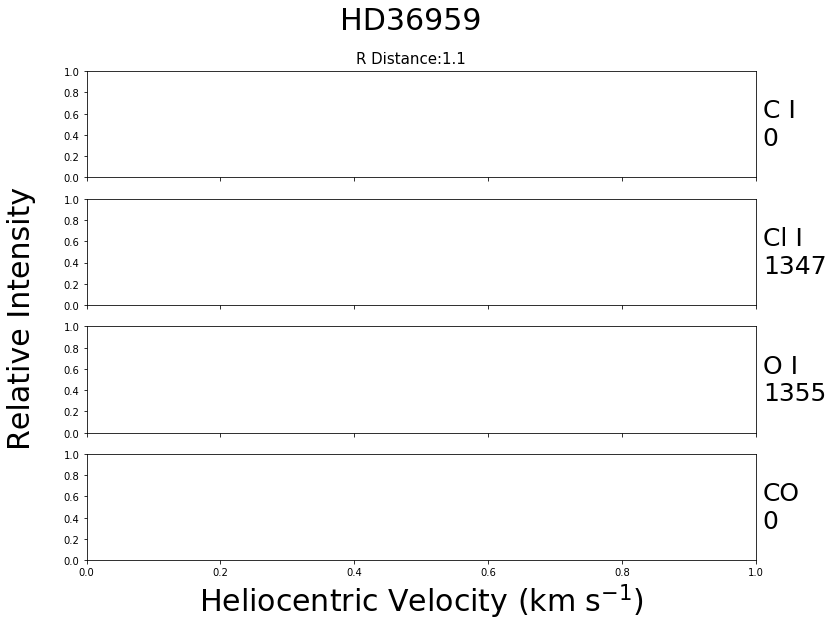

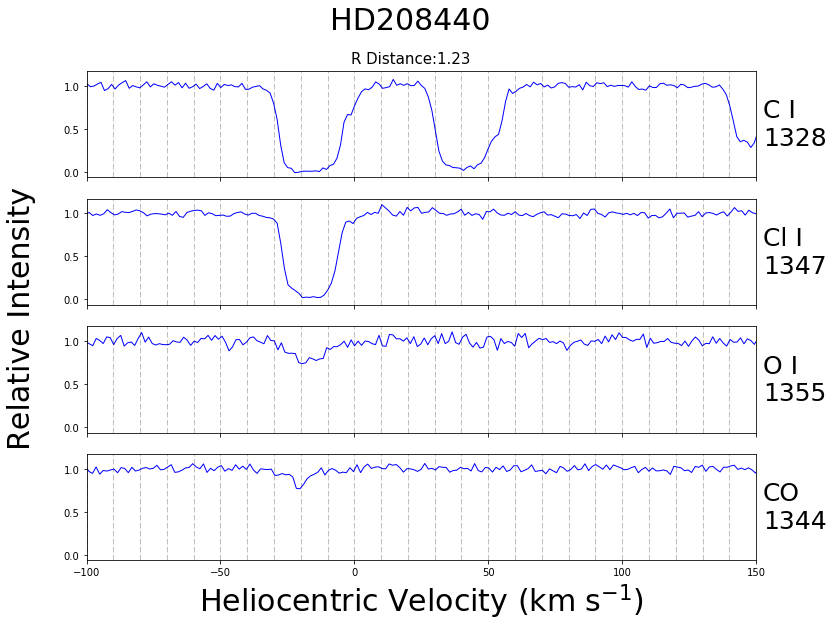

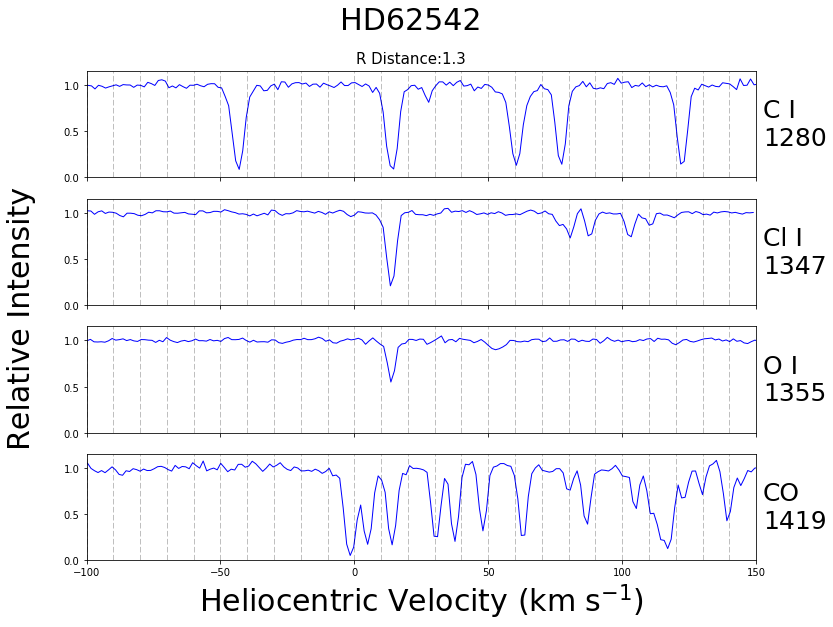

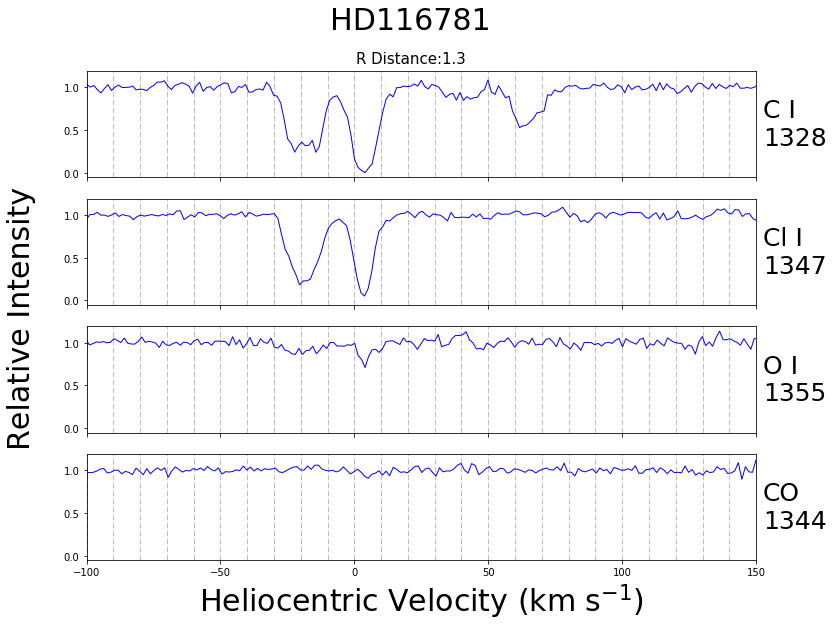

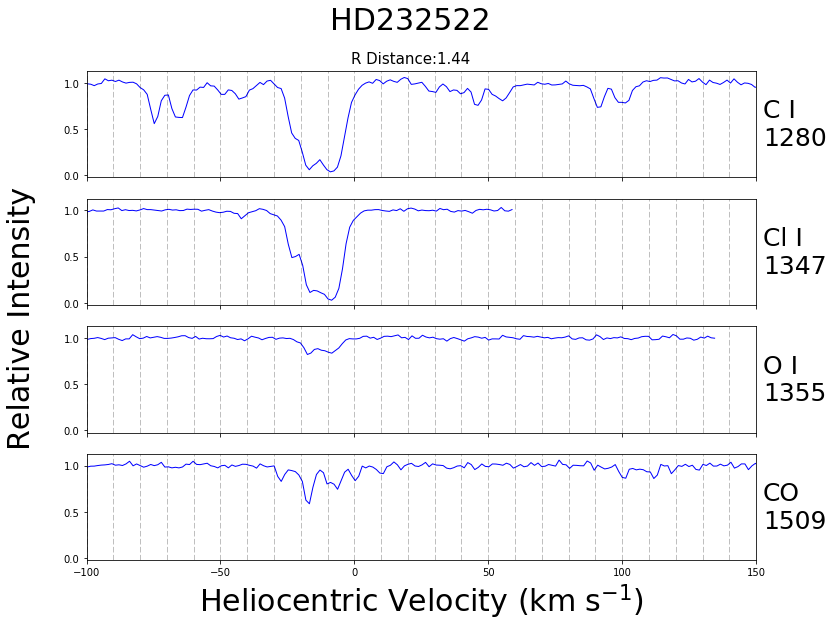

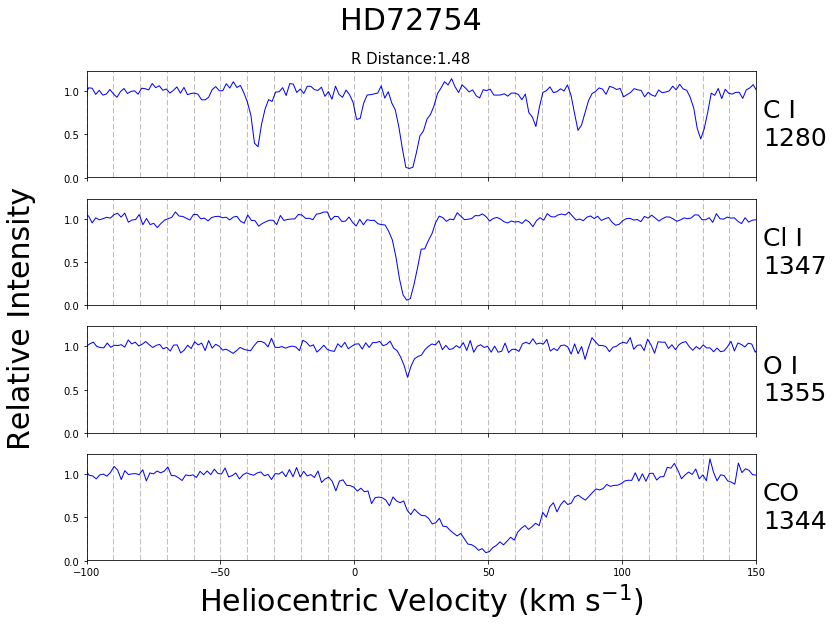

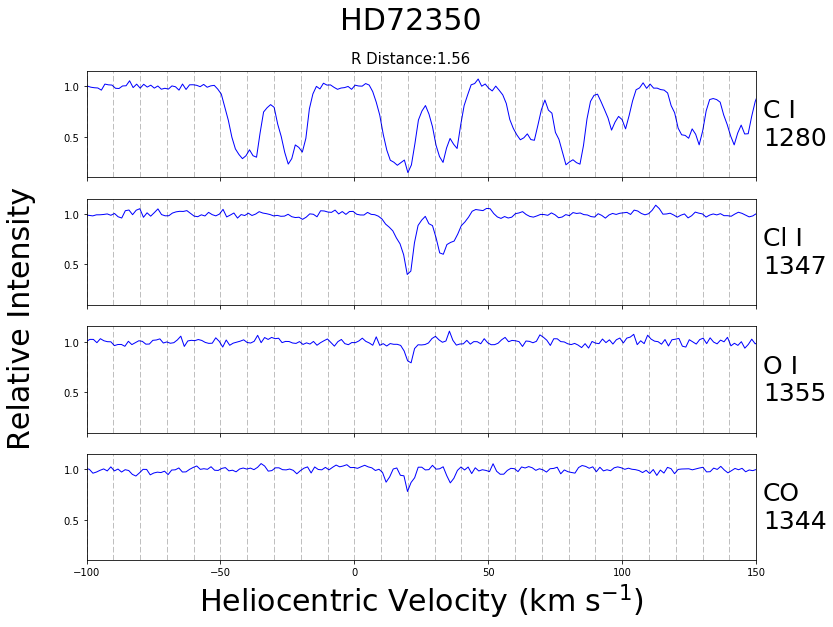

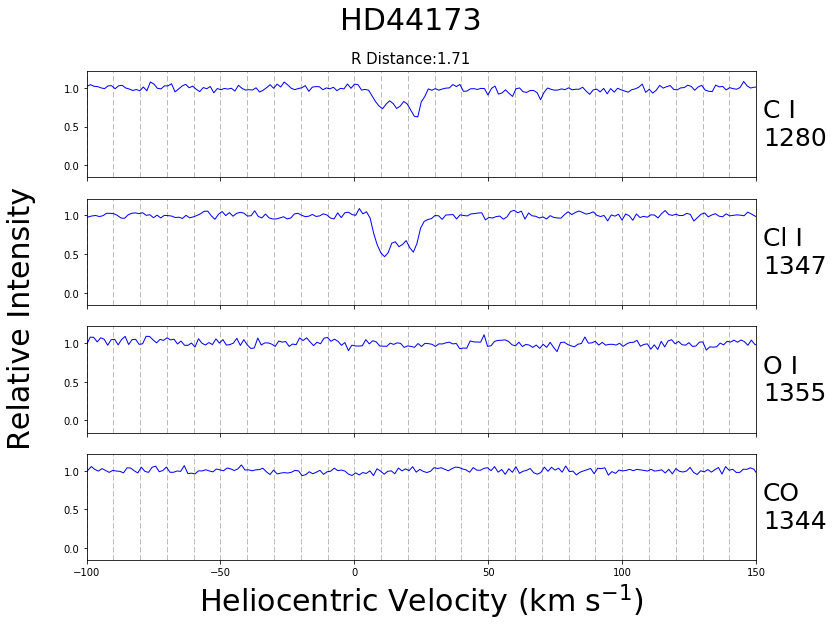

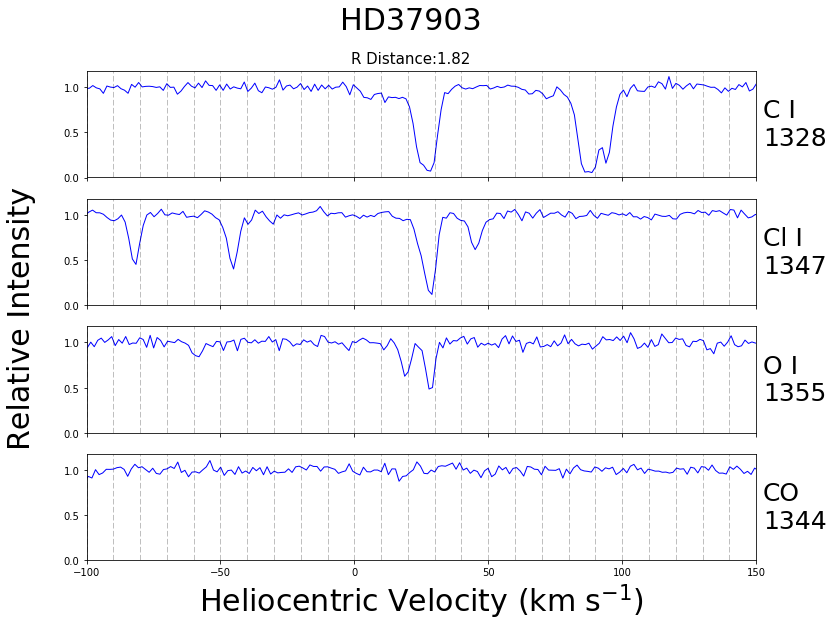

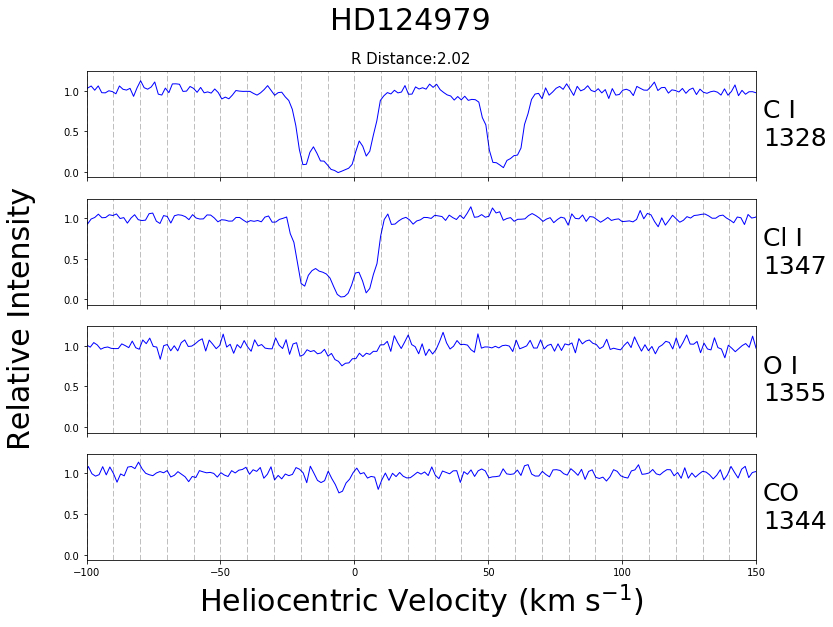

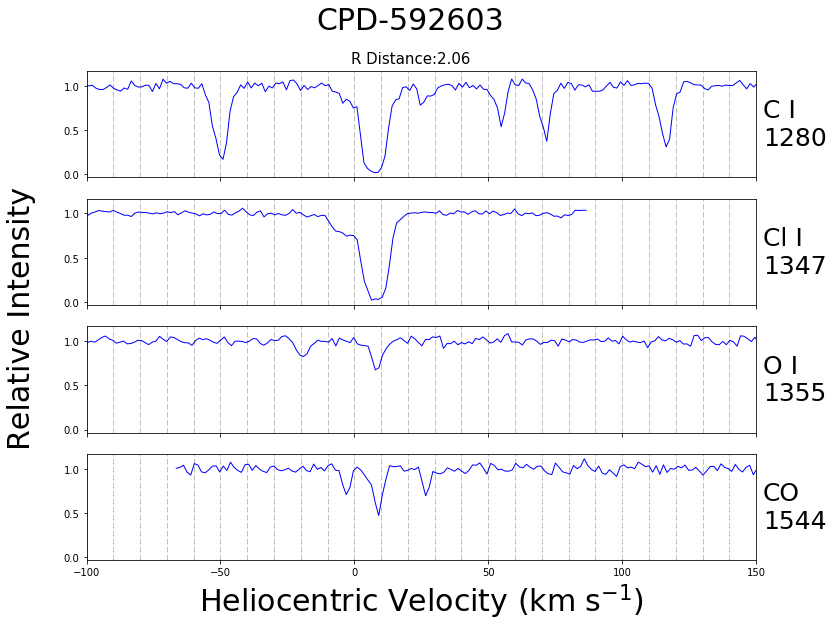

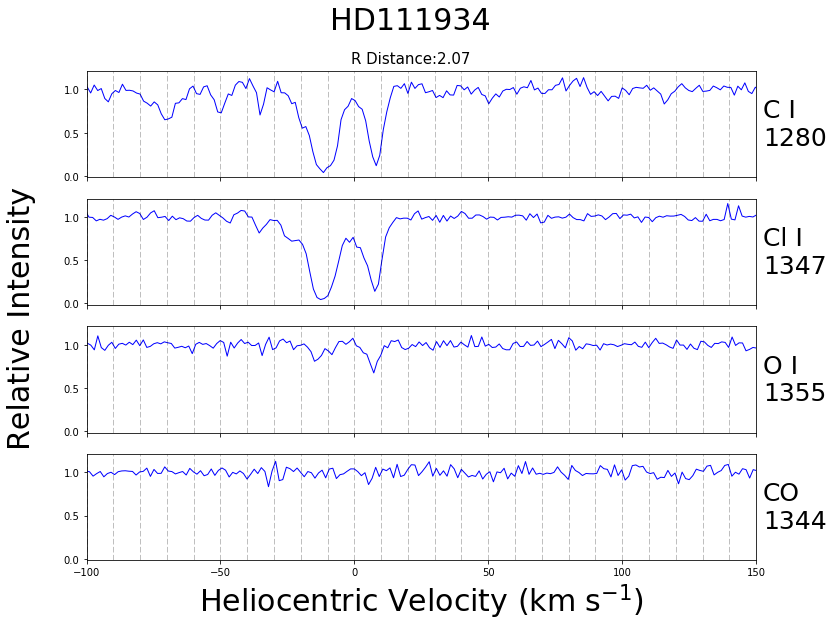

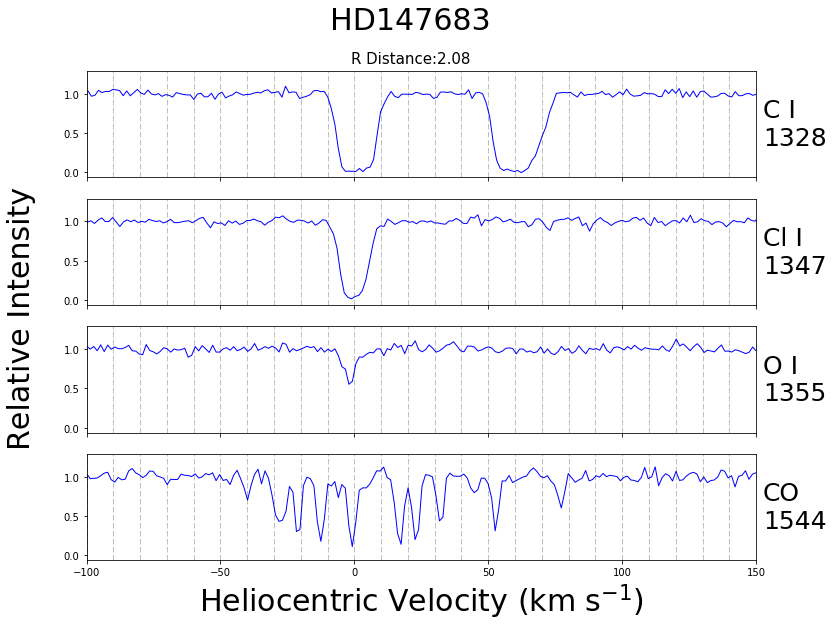

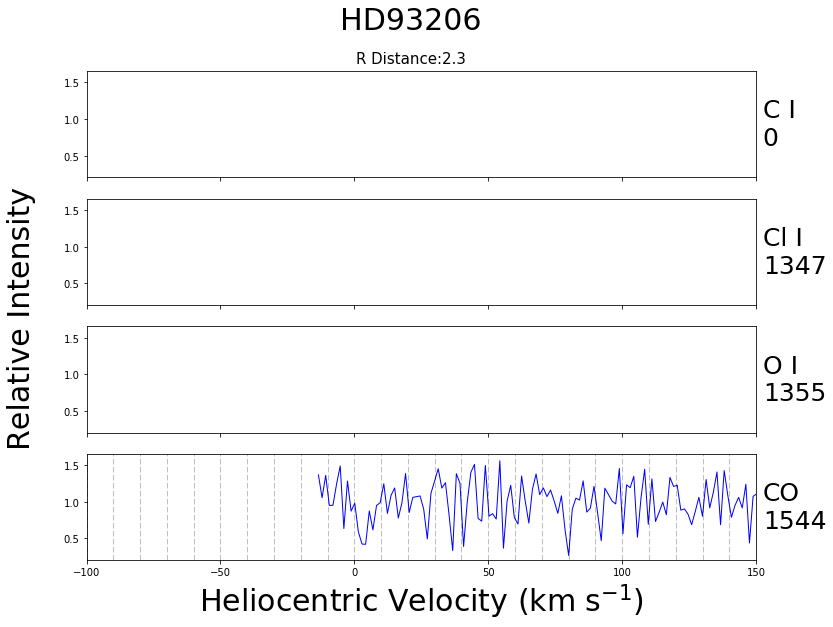

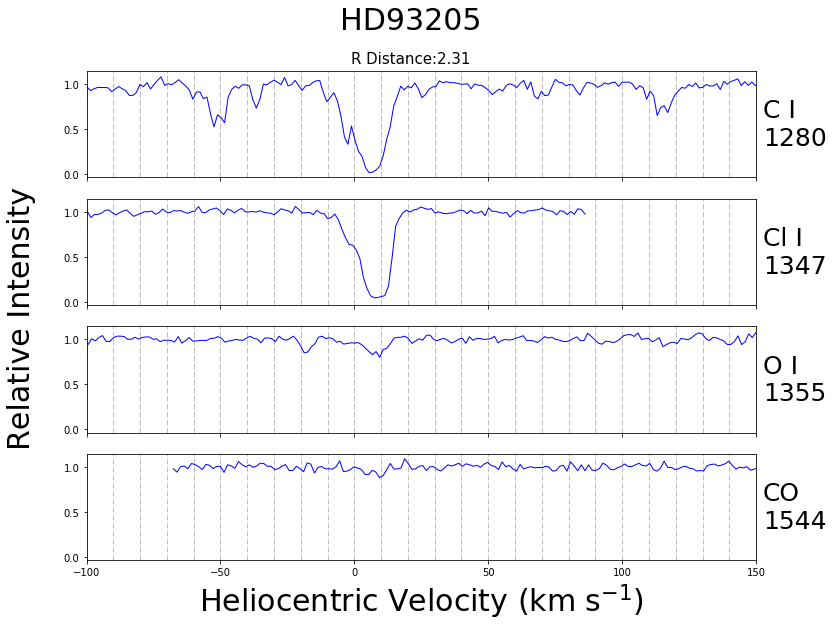

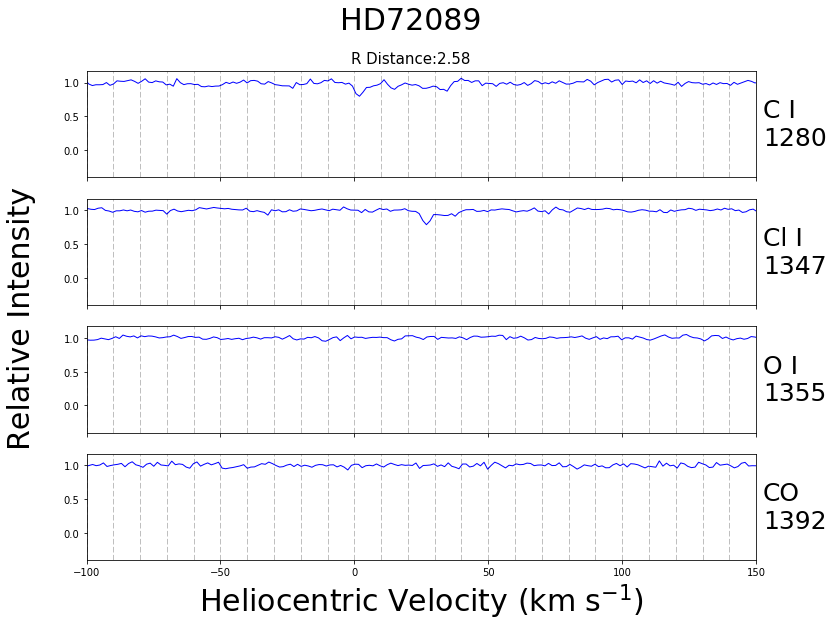

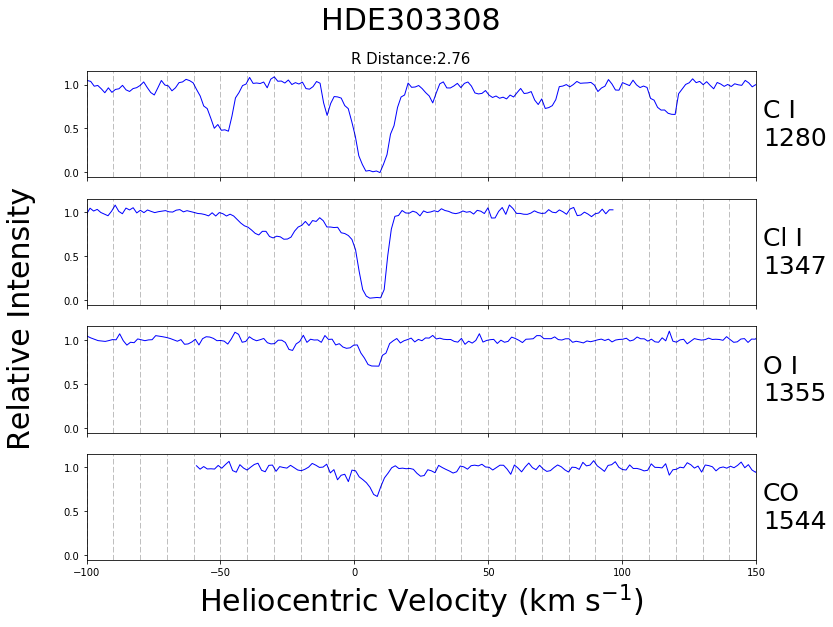

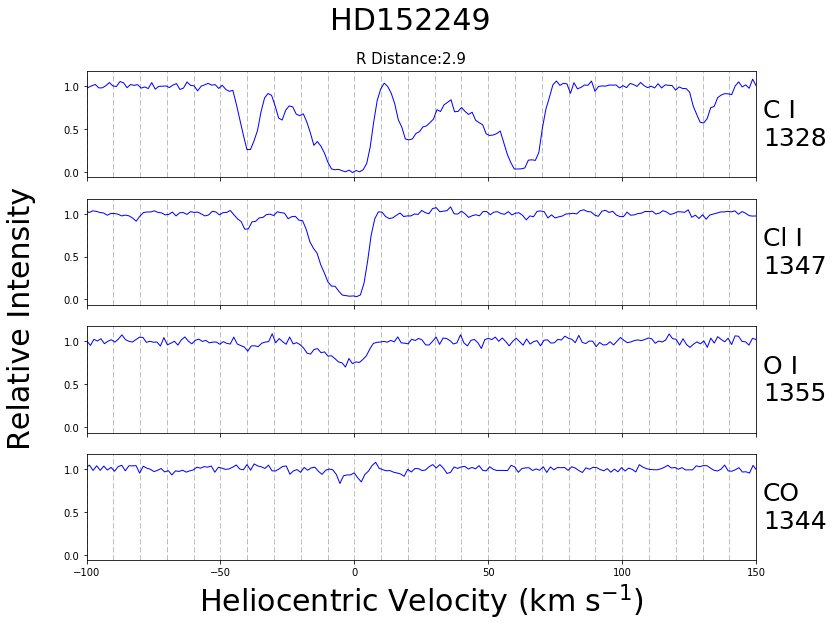

In [32]:
species=['C I','Cl I','O I','CO']
cen_wavs=[
    [1328.833,1280.1353],
    [1347.2396],
    [1355.5977],
    [1544.448,1509.748,1477.565,1447.352,1419.044,1392.525,1367.623,1344.186,1322.15,1301.403,1281.866,1263.433,1246.059]]
pdf=PdfPages('3sigmaspectra.pdf')
for result in three_sig:
    sightline=result[0][0]
    f,subplts=plt.subplots(4,sharex=True,sharey=True,figsize=(12,9))
    f.text(0.05,0.5,'Relative Intensity', rotation=90,fontsize=30,ha='center',va='center')
    f.text(0.5,0.9,'R Distance:'+str(round(get_r_dist(result[1],result[0][1][0].value,result[0][1][1].value),2)),
           fontsize=15,ha='center',va='center')
    f.suptitle(sightline,fontsize=30)
    yMajorLocator=ticker.MultipleLocator(0.5)
    xspac=50
    xMajorLocator=ticker.MultipleLocator(xspac)
    for lams in cen_wavs:
        cen_wav=0
        idx=cen_wavs.index(lams)
        subplt=subplts[idx]
        if len(lams)==1:
            cen_wav=lams[0]
        else:
            for lam in lams:
                filename=top_level+'x1d_files/'+sightline+'/E140H/'+sightline+'_'+str(lam)+'.dat'
                if os.path.isfile(filename):
                    cen_wav=lam
                    break
                    
        subplt.text(1.01,0.5,species[idx]+'\n'+str(int(cen_wav)),transform=subplt.transAxes,fontsize=25,ha='left',va='center')
        filename=top_level+'x1d_files/'+sightline+'/E140H/'+sightline+'_'+str(cen_wav)+'.dat'
        if os.path.isfile(filename):
            fl=open(top_level+'x1d_files/'+sightline+'/E140H/'+sightline+'_'+str(cen_wav)+'.dat')
            wavs=[]
            flxs=[]
            for line in fl:
                wav,flx=line.strip().split()
                wavs.append(float(wav))
                flxs.append(float(flx))

            vels=(300000./cen_wav)*(np.array(wavs)-cen_wav)
            subplt.plot(vels,flxs,'b-',lw=1)

            subplt.set_xlim(-100,150)
            for vline in np.arange(-100,150,10):
                subplt.axvline(vline,0,1,linestyle='--',color='k',linewidth=0.5,alpha=0.5)
            subplt.yaxis.set_major_locator(yMajorLocator)
            subplt.xaxis.set_major_locator(xMajorLocator)

    subplts[3].set_xlabel('Heliocentric Velocity (km s$^{-1}$)',fontsize=30)
    pdf.savefig()
    
pdf.close()